In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Secret data generating mechanism that as the optimisation engineer you don't have access to. 
# However, to evaluate the final solution beyond the training objective 
# (which is quite likely close to zero for any training procedure due to huge number of parameters) 
# we need access to w_star. 

# You may feel free to use the variable data_dim. All other variables here are off limits. 

# Data description: 30 data points for 100 dimensional regression problem. 

data_dim = 100
num_data = 30
sparsity = 3
np.random.seed(100) 
w_temp = np.random.randn(sparsity)
indices = np.random.choice(data_dim, sparsity, replace=False)
w_star=np.zeros(data_dim)
w_star[indices]=w_temp

data_matrix = np.random.randn(num_data, data_dim)*0.5
labels = np.dot(data_matrix, w_star) + 0.0*np.random.randn(num_data)



global_A = np.dot(data_matrix.T, data_matrix) / num_data
global_b = np.dot(data_matrix.T,labels) / num_data
global_c = 0.5* np.dot(labels, labels) / num_data
global_w_star = np.array(w_star)

print('w_star=', global_w_star)
print('Non-zero coeffs=', np.where(np.abs(global_w_star)>1e-5))
eig_vals, eig_vecs = np.linalg.eig(global_A)
smoothness_coeff = np.real(np.max(eig_vals))
print('Smoothness coeff=', smoothness_coeff)



w_star= [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.1530358   0.          0.
  0.         -1.74976547  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.3426804   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

In [3]:

def get_value(w):
    A = global_A
    b = global_b
    return 0.5*np.dot(w, np.dot(A,w)) - np.dot(b,w) + global_c

def get_gradient(w):
    A = global_A
    b = global_b
    return np.dot(A,w)-b

    

# Question 1:

Assume you have oracle access to a regression error function (call it f) on some training data. Solve the LASSO optimisation problem, over some given l1 norm ball using the projected gradient descent.

1. Write the function for the l1 norm projection oracle, l2 norm projection oracle and the respective PGD steps.

2. Plot f(w_t) vs t for the PGD algorithm with l2 norm projection oracle. The step size is fixed to eta=0.01. Repeat the plots with different l2 norm constraints: 0.1, 0.5, 1, 2, 5 (on the same plot). 

3. Plot f(w_t) vs t for the PGD algorithm with l1 norm projection oracle. The step size is fixed to eta=0.01. Repeat the plots with different l1 norm constraints: 0.1, 0.5, 1, 2, 5 (on the same plot).

4. Let $w^1_\lambda$ be the result of running PGD with the l1 norm constraint of lambda for 500 iterations. Similarly let $w^2_\mu$ be the result of running PGD with the l2 norm constraint of mu for 500 iterations. Give two separate cells with each cell containing 2 plots as follows: 

    4a. In the first cell: $f(w^1_\lambda)$ vs $\lambda$ and $||w^1_\lambda - w^* ||$ vs $\lambda$.    
    4b. In the Second cell: $f(w^2_\mu)$ vs $\mu$ and $||w^2_\mu - w^* ||$ vs $\mu$. 
    
    Note 1: $w^*$ is the vector used in data generation. 
    Note 2: Using $w^*$ is illegal anywhere else. But it's okay here to just make a point.
    Note 3: The range of mu and lambda to plot may be taken to be 0.1 to 3.
    Note 4: We can take the norm above to simply be the difference in the set of non-zero components

5. Summarise and explain your findings in a markdown cell

In [8]:
# Question 1 part 1

def projection_oracle_l2(w, l2_norm):
    wn=np.linalg.norm(w)
    if wn>l2_norm:
        return w*(l2_norm/wn)
    else:
        return w

def projection_oracle_l1(w, l1_norm):
    n, = w.shape
    wsig = np.sign(w)
    wabs = np.abs(w)
    sum=0
    for i in wabs:
        sum=sum+i
    if sum<=l1_norm:
        return w
    q = np.sort(wabs)[::-1]
    cs=np.zeros(q.size)
    cs[0]=q[0]
    for i in range(1,len(q)):
        cs[i]=cs[i-1]+q[i]
    r=-1
    for i in range(n):
        if (cs[i]-l1_norm)/(i+1)<q[i]:
            r=max(r,i)
    t = float(cs[r]-l1_norm)/(r+1)
    w = (wabs - t).clip(min=0)
    w = w*wsig
    
    return w
    
def PGD_step_l2(w, l2_norm, eta=0.1):
    wa = w - eta*get_gradient(w)
    wb = projection_oracle_l2(wa,l2_norm)
    return wb

def PGD_step_l1(w, l1_norm, eta=0.1):
    wa = w - eta*get_gradient(w)
    wb = projection_oracle_l1(wa,l1_norm)
    return wb


Text(0.5, 1.0, 'Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')

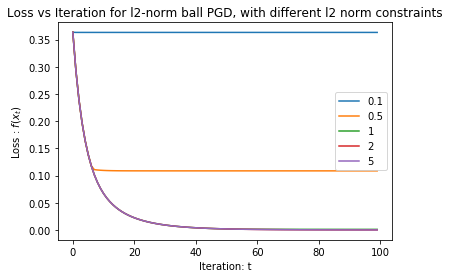

In [11]:
# Question 1 part 2

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)

    for t in range(100):
        w = PGD_step_l2(w, norm_constraint)
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')




Text(0.5, 1.0, 'Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')

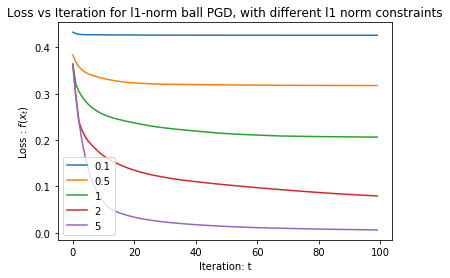

In [12]:
# Question 1 part 3

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l1(w, norm_constraint)
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')


Text(0.5, 1.0, 'L2 norm projected gradient descent')

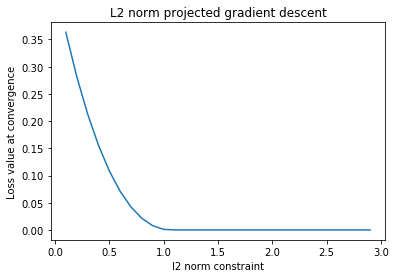

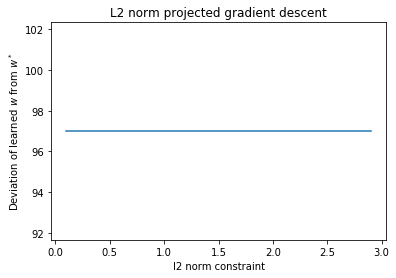

In [13]:
# Question 1 part 4a

norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l2(w, norm_constraint)
    loss_values.append(get_value(w))

    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l2 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L2 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l2 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L2 norm projected gradient descent')

Text(0.5, 1.0, 'L1 norm projected gradient descent')

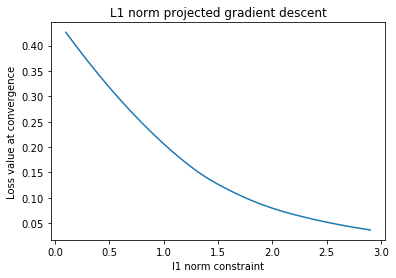

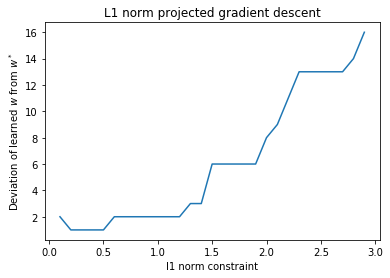

In [14]:
# Question 1 part 4b

norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l1(w, norm_constraint)
    loss_values.append(get_value(w))
    
    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l1 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L1 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l1 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L1 norm projected gradient descent')


### Question 1 Part 5:
Projected Gradient Descent for l2-norm:

    l2-norm ball with larger radius has larger loss at convergence when compared to the ball with lesser radius 
    
    for a given learning rate it takes more iters for the l2-norm ball with larger radius when compared to ones with lesser radius
    
    deviation of learned w from w* is same for all l2-norm balls
   
   
Projected Gradient Descent for l1-norm:

    loss at convergence is larger for l1-norm ball with larger l1-norm value when compared to l1-norm ball with smaller radius
    
    deviation of learned w from w* fluctuates as l1-norm value increases


# Question 2:

Assume you have oracle access to a regression error function (call it f) on some training data. Solve the LASSO optimisation problem, over some given l1 norm ball using the Frank-Wolfe method. 

1. Write the function for the l1 norm LMO, l2 norm LMO and the respective FW steps.

2. Plot f(w_t) vs t for the FW algorithm with l2 norm LMO. Repeat the plots with different l2 norm constraints: 0.1,0.5,1,2,5 (on the same plot). 

3. Plot f(w_t) vs t for the FW algorithm with l1 norm LMO. Repeat the plots with different l1 norm constraints: 0.1,0.5,1,2,5 (on the same plot). 

4. Let $w^1_\lambda$ be the result of running FW with the l1 norm constraint of lambda for 500 iterations. Similarly let $w^2_\mu$ be the result of running FW with the l2 norm constraint of mu for 500 iterations. Give two separate plots with each plot containing 2 curves as follows: 

    4a. In the first plot: $f(w^1_\lambda)$ vs $\lambda$ and $||w^1_\lambda - w^* ||$ vs $\lambda$.    
    4b. In the Second plot: $f(w^2_\mu)$ vs $\mu$ and $||w^2_\mu - w^* ||$ vs $\mu$. 
    
    Note 1: $w^*$ is the vector used in data generation. 
    Note 2: Using $w^*$ is illegal anywhere else. But it's okay here to just make a point.
    Note 3: The range of mu and lambda to plot may be taken to be 0.1 to 3.
    Note 4: We can take the norm above to simply be the difference in the set of non-zero components
    
5. Summarise and explain your findings on 2,3,4 above in a markdown cell

In [26]:
# Question 2 part 1


def LMO_l2(u, l2_norm):
    grad = get_gradient(u)
    a = l2_norm/np.linalg.norm(grad)
    d = -a*grad
    return d

def LMO_l1(u, l1_norm):
    grad = get_gradient(u)
    ind=-1
    ma=-1
    for i in range(grad.size):
        if ma<grad[i]:
            ma=grad[i]
            ind=i
    if grad[ind]<0:
        n=l1_norm
    else:
        n=-1*l1_norm
    d = np.zeros(u.size)
    d[ind] = d[ind] + n
    return d
    
    
def FW_step_l2(w, l2_norm, gamma):
    return (1-gamma)*w + gamma*LMO_l2(w,l2_norm)

def FW_step_l1(w, l1_norm, gamma):
    return (1-gamma)*w + gamma*LMO_l1(w,l1_norm)



Text(0.5, 1.0, 'Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')

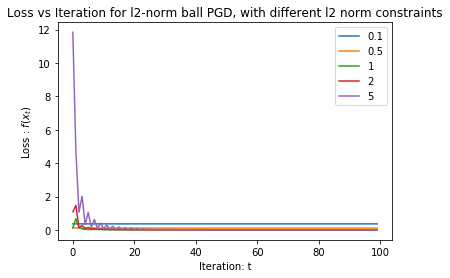

In [27]:
# Question 2 part 2

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)

    for t in range(100):
        w = FW_step_l2(w, norm_constraint, gamma=2./(t+2))
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')




Text(0.5, 1.0, 'Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')

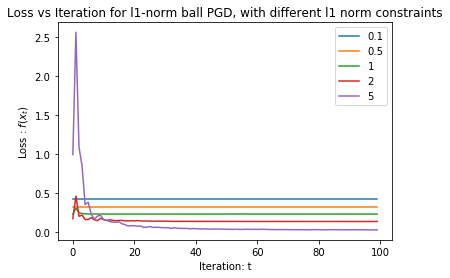

In [28]:
# Question 2 part 3

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l1(w, norm_constraint, gamma=2./(t+2))
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')

Text(0.5, 1.0, 'L2 norm projected gradient descent')

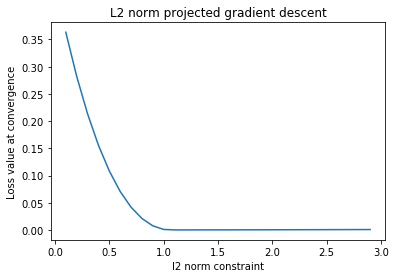

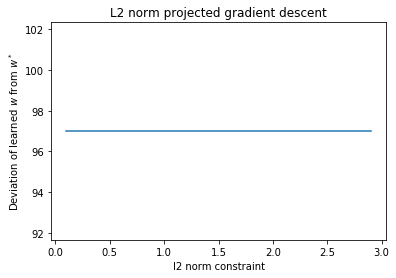

In [18]:
# Question 2 part 4a


norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l2(w, norm_constraint, gamma=2./(t+2))
    loss_values.append(get_value(w))

    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l2 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L2 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l2 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L2 norm projected gradient descent')

Text(0.5, 1.0, 'L1 norm projected gradient descent')

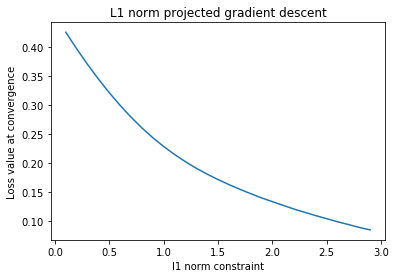

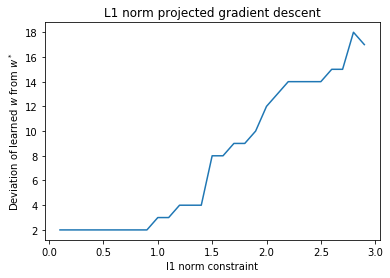

In [19]:
# Question 2 part 4b


norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l1(w, norm_constraint, gamma=2./(t+2))
    loss_values.append(get_value(w))
    
    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l1 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L1 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l1 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L1 norm projected gradient descent')


### Question 2 part 5
Projected Gradient Descent for l1-norm:

    loss at convergence is more for l1-norm ball with larger l1-norm value when comapared to l1-norm ball with smaller l1-norm value
    
Projected Gradient Descent for l2-norm:
    
    loss at convergence is more for l2-norm ball with larger l2-norm radius when comapared to l2-norm ball with smaller l2-norm radius

